In [14]:
import numpy as np
import pandas as pd

from skimage import io
from skimage.filters import threshold_otsu
from skimage.morphology import binary_dilation# , ball

import os
from matplotlib import pyplot as plt
import napari
from tqdm import tqdm
import pickle
import xarray as xr

import pydeform.sitk_api as pydeform
# from scipy import interpolate
# import ants
# import SimpleITK as sitk

# from vispy import color
from vispy.color import Colormap

In [2]:
import importlib
import morphotrack.variables
import morphotrack.points
import morphotrack.track
import morphotrack.binary
import morphotrack.image
import morphotrack.align
import morphotrack.nonlinear_align
import morphotrack.distance
import morphotrack.dtw
importlib.reload(morphotrack.points)

<module 'morphotrack.points' from '/home/tmurakami/src/morphotrack/morphotrack/points.py'>

In [3]:
io_directory = '/mnt/ampa_data01/tmurakami/220715_prefrontal_q2_R01/morphotrack'
# load blood vessel
vessel = io.imread(os.path.join(io_directory,'R01_ch561_10um.tif'))

# load nuclei
nuclei = io.imread(os.path.join(io_directory,'R02_ch488_10um.tif'))

# load a mask of a white matter 
white_matter = io.imread(os.path.join(io_directory,'white_matter.tif'))!=0

# load a mask of a layer 1
layer1 = io.imread(os.path.join(io_directory,'l1.tif'))!=0

# segmentated tissue
segmented_tissue = io.imread(os.path.join(io_directory,'tissue_mask.tif'))!=0

# read cellular coordinate
cells_info = pd.read_csv('/mnt/ampa_data01/tmurakami/220715_prefrontal_q2_R01/R02_R01/R02ch488_to_R01_segmentation/coord_centroids.csv',index_col=0) # the unit is original voxel.
scaling_factor = np.asarray([3,0.65,0.65])
cell_coords = cells_info.loc[:,['centroid-0','centroid-1','centroid-2']] * scaling_factor / 10# convert unit to 10 um for consistency
cell_coords = cell_coords.to_numpy()

# load regression model
reg = pickle.load(open(os.path.join(io_directory,'model_debug2.pkl'), 'rb'))
norm_flow_on_coordinate = morphotrack.points.model_to_norm_flow_func(reg.degree, reg)

In [4]:
# visual sanity check
viewer= napari.Viewer()
viewer.add_image(layer1, blending='additive')
viewer.add_image(white_matter, blending='additive')
viewer.add_image(nuclei, blending='additive')
viewer.add_image(segmented_tissue, blending='additive')

<Image layer 'segmented_tissue' at 0x7f1be757afa0>

In [6]:
track_info = xr.open_dataset(os.path.join(io_directory,"track_info.nc")).load()

## Count in-kernel cells

In [8]:
%%time
half_thickness = 2.5 # * 10 micrometer. half of the thickness
radius = 10 # * 10 micrometer
kernel_counts = morphotrack.points.count_around_position_in_disk_kernel(track_info.Position, cell_coords, half_thickness, radius)
kernel_counts = kernel_counts.fillna(0)

CPU times: user 6min 41s, sys: 40.6 s, total: 7min 21s
Wall time: 4min 39s


In [9]:
viewer = napari.Viewer()
viewer.add_image(kernel_counts)

<Image layer 'kernel_counts' at 0x7f1c544b6160>

## Filtering with white matter and tissue shape

In [10]:
# get binary mask for gray matter
gray_candidate = (1-white_matter)*segmented_tissue

# get segments where tracks are in gray matter
gray_loc = morphotrack.points.fetch_value_in_position(track_info.Position, gray_candidate) # tracker.fetch_value_in_position(gray_candidate)
gray_loc = gray_loc.astype(float).fillna(0)
gray_loc.data = np.apply_along_axis(lambda a:morphotrack.binary.extract_largest_object_from_binary(a, np.ones(3)), axis=1, arr=gray_loc.data) # extract the longest segment

# make filter based on the size of the segment
filters = []
size_threshold = 50
filters.append(gray_loc.sum(dim='time')>=size_threshold)

# make filter based on one edge is white matter
white_loc = morphotrack.points.fetch_value_in_position(track_info.Position, white_matter) # tracker.fetch_value_in_position(white_matter)
white_loc = white_loc.astype(float).fillna(0)
extension_param = 10
temp = gray_loc.copy()
temp.data = np.apply_along_axis(lambda a:binary_dilation(a, np.hstack([np.zeros(extension_param),np.ones(extension_param)])), axis=1, arr=gray_loc.data)
filters.append(((temp.astype(int)-gray_loc.astype(int))*white_loc).sum(dim='time')>0)

# make filter based on inclusion of layer1
l1_loc = morphotrack.points.fetch_value_in_position(track_info.Position, layer1) # tracker.fetch_value_in_position(layer1)
l1_loc = l1_loc.astype(float).fillna(0)
filters.append(l1_loc.sum(dim='time')>0)

# dilate to obtain redundancy for alignment
gray_extension = 5
gray_loc.data = np.apply_along_axis(lambda a:binary_dilation(a, np.hstack([np.zeros(gray_extension),np.ones(gray_extension)])), axis=1, arr=gray_loc.data)

# summarize filters
filters = xr.concat(filters,dim='filt')

In [15]:
# Visualize tracks
position = track_info.Position.sel(track=filters.track[filters.all(dim='filt').data].data)
position = position.stack(pos=['time', 'track']).data.T
selection = gray_loc.sel(track=filters.track[filters.all(dim='filt').data].data)
selection = selection.stack(pos=['time', 'track']).data

position[np.isnan(position)] = 0
position[~selection,:] = 0

flow_vector = abs(norm_flow_on_coordinate(position))
flow_img = np.zeros(vessel.shape+(vessel.ndim,))
for i in range(vessel.ndim):
    flow_img[...,i] = morphotrack.image.fill_value_in_range(flow_img[...,i],position.T,flow_vector[:,i])
    flow_img[...,i] = flow_img[...,i]*segmented_tissue
    
viewer = napari.Viewer()
viewer.add_image(vessel, contrast_limits=[0,20000], rgb=False, name='sma', colormap='gray', blending='additive')

palette = [
    Colormap([[1.0, 1.0, 1.0, 0.0], [1.0, 0.0, 0.0, 1.0]]),
    Colormap([[1.0, 1.0, 1.0, 0.0], [0.0, 1.0, 0.0, 1.0]]),
    Colormap([[1.0, 1.0, 1.0, 0.0], [0.0, 0.0, 1.0, 1.0]])]

for i in range(vessel.ndim):
    viewer.add_image(flow_img[...,i], contrast_limits=[0,1], rgb=False, name=i, colormap=palette[i], blending='translucent')

viewer.add_image(segmented_tissue, contrast_limits=[0,2], rgb=False, name='mask', colormap='cyan', blending='additive', multiscale=False, visible=False)

<Image layer 'mask' at 0x7f1c47da9e80>

## Alignment

### Linear alignment
linearly transform the tracks to fit standard

In [17]:
# get tracks for analysis
track_selection = filters.track[filters.all(dim='filt')]

# create xarray dataset
track_ds = xr.Dataset(data_vars={'Kernel_counts': kernel_counts.isel(track=track_selection), 'Gray_loc': gray_loc.isel(track=track_selection)})
track_ds['Gray_counts'] = track_ds.Kernel_counts * track_ds.Gray_loc

# position and flow for future reference
track_ds['Position'] = track_info.Position.isel(track=track_selection.data)
track_ds['Flow'] = track_info.Flow.isel(track=track_selection.data)
track_ds['Seeds'] = track_info.Seed.isel(track=track_selection.data)

In [23]:
# get a standard as a template of alignment
std_pos = morphotrack.points.pick_median_nearest_point(track_ds['Seeds'],1)
# std_pos = 1147 # or set manually
std_seed = track_ds['Seeds'][std_pos,:].track.data
standard = morphotrack.align.standard_generator(track_ds.Gray_counts,std_seed)

# linear transformation of the tracks to the standard track
args, disps = morphotrack.align.linear_shift_to_standard(track_ds.Gray_counts,std_seed)

# save to track dataset
track_ds['Standard'] = standard
track_ds['Linear_arg'] = args
track_ds['Linear_warped'] = disps

In [87]:
viewer = napari.Viewer()
viewer.add_image(track_ds.Gray_counts,colormap='green',blending='additive',visible=False)
viewer.add_image(track_ds.Standard,colormap='green',blending='additive')
viewer.add_image(track_ds.Linear_warped.sel(displacement='t2s'),colormap='magenta',blending='additive')
# labels = viewer.add_labels(np.zeros_like(track_ds.Standard.astype(int)), name='labeling')

<Image layer 'Image [2]' at 0x7f96bfedba00>

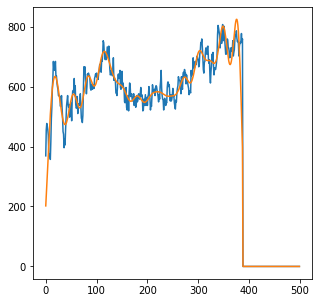

In [24]:
# check FFT filter threshold
threshold = 1e3
fig, axs = plt.subplots(figsize=(5,5))
axs.plot(track_ds.Standard.isel(track=0).data)
fft_filtered = morphotrack.dtw.filter_signal(track_ds.Standard.isel(track=0).data,threshold=threshold)
fft_filtered[track_ds.Standard.isel(track=0).data==0]=0
axs.plot(fft_filtered)

### Non-linear alignment
The alignment is further finely tuned by non-linear 1d registration

In [93]:
settings = {
    'pyramid_levels':3,
    'pyramid_stop_level': 0,
    'step_size': [1.0, 1.0, 1.0],
    'block_size': [128,128,128],
    'block_energy_epsilon':1e-7,
    'max_iteration_count':100,
    'constraints_weight':1000.0,
    'regularization_weight': 0.25, # default 0.25
    'regularization_scale': 1.0, # default 1.0
    'regularization_exponent': 2.0, # default 2.0
    'image_slots':[{
            'resampler': 'gaussian',
            'normalize': True,
            'cost_function':[
                {
                    'function':'ncc',
                    'weight':1.0,
                    'radius':21
                }
            ]
        }]
}

In [94]:
non_linear_args = morphotrack.nonlinear_align.track_wise_aligner(track_ds.Standard.data, track_ds.Linear_warped.sel(displacement='t2s').data,fft_threshold=threshold, settings=settings)

100%|████████████████████████████████████████████████████████████████████████████████████| 2739/2739 [1:36:35<00:00,  2.12s/it]


In [95]:
# store non linear displacement in xarray
non_linear_arg_xr = track_ds.Linear_arg.copy()
non_linear_arg_xr[:] = np.asarray(non_linear_args[::-1])
track_ds['Nonlinear_arg'] = non_linear_arg_xr

# make total displacement 
comp_disps = []
for x in track_ds.Nonlinear_arg.displacement.data:
    comp_disps.append(morphotrack.align.composite_displacement(track_ds.Linear_arg.sel(displacement=x),track_ds.Nonlinear_arg.sel(displacement=x)))

# store total displacement in xarray
total_arg_xr = track_ds.Linear_arg.copy()
total_arg_xr[:] = np.asarray(comp_disps)
track_ds['Total_arg'] = total_arg_xr

# make total warped tracks
s2t_non_linear_warped = morphotrack.align.positional_mapping(track_ds.Standard, track_ds.Total_arg.sel(displacement='s2t'))
t2s_non_linear_warped = morphotrack.align.positional_mapping(track_ds.Gray_counts, track_ds.Total_arg.sel(displacement='t2s'))

# store total warp in xarray
total_warp_xr = track_ds.Linear_arg.copy()
total_warp_xr[:] = np.asarray([s2t_non_linear_warped, t2s_non_linear_warped])
track_ds['Total_warped'] = total_warp_xr

In [96]:
viewer = napari.Viewer()
viewer.add_image(track_ds.Gray_counts,colormap='green',blending='additive',visible=False)
viewer.add_image(track_ds.Standard,colormap='green',blending='additive')
viewer.add_image(track_ds.Total_warped.sel(displacement='t2s'),colormap='magenta',blending='additive')
viewer.add_image(track_ds.Total_warped.sel(displacement='s2t'),colormap='magenta',blending='additive',visible=False)

<Image layer 'Image [3]' at 0x7f96be113fd0>

## local flux map. quality metrics.
### quality metrics and filitering

In [97]:
std = track_ds.Total_warped.sel(displacement='t2s',track=std_seed)# track_ds.Standard.sel(track=std_seed)

# get cosine similarities
cs = np.apply_along_axis(morphotrack.track.cosine_similarity, 1, track_ds.Total_warped.sel(displacement='t2s'), std)
# get mutual information
mi = np.apply_along_axis(morphotrack.track.mutual_information, 1, track_ds.Total_warped.sel(displacement='t2s'), std)

# thresholding with otsu
cs_thresh = threshold_otsu(cs)
mi_thresh = threshold_otsu(mi)

# # selection of tracks
# select_tracks = track_ds.track[(cs>=cs_thresh)&(mi>=mi_thresh)]
# selected_track_ds = track_ds.sel(track=select_tracks)

# save in track_ds
qc_array = xr.DataArray(np.stack([cs,mi]).T,
                        coords={'track': track_ds.track,
                             'metrics': ['cs','mi']},
                        dims=['track', 'metrics'],
                        attrs=dict(cs_thresh=cs_thresh,mi_thresh=mi_thresh)
                        )

track_ds['Similarity'] = qc_array

### compression map

In [98]:
# convert position to distance
dist = morphotrack.distance.position2distance_xr(track_ds.Position)

# adjust positions to match the standard, and convert the positions to distance.
position_in_standard = morphotrack.distance.map2standard_vectorspace_xr(track_ds.Total_arg.sel(displacement='s2t'),track_ds.Position.sel(track=std_seed))
dist_in_standard = morphotrack.distance.position2distance_xr(position_in_standard)

# take moving average and get log fold changes. this produces compression map.
window = 10
logfc = morphotrack.distance.logFC_distance_t2s(dist_in_standard, dist_in_standard.sel(track=std_seed), window)
logfc = logfc.assign_attrs(window=window)
track_ds['LogCompression'] = logfc

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning:

divide by zero encountered in log2

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning:

invalid value encountered in log2



In [64]:
viewer = napari.Viewer()
viewer.add_image(logfc,contrast_limits=[-2,2],colormap='twilight',blending='additive')

<Image layer 'logfc' at 0x7f91d34ea190>

In [65]:
# img = morphotrack.image.visualize_in_original_space(track_ds.Position, logfc, vessel.shape)

# viewer = napari.Viewer()
# viewer.add_image(img,contrast_limits=[-2,2],colormap='twilight',blending='additive')
# viewer.add_image(nuclei,colormap='gray',blending='additive')

### local flux map

In [99]:
layer_position = []
for tr in track_ds.track.data:
    interp_position = track_ds.Position.sel(track=tr).interp(time=track_ds.Total_arg.sel(displacement='t2s').sel(track=tr).data)
    interp_position = interp_position.assign_coords(time=np.arange(t_start,t_end))
    layer_position.append(interp_position)
layer_position = xr.concat(layer_position,dim='track')
layer_position = layer_position.rename(time='warped_time')

In [100]:
local_flux = []
for t in tqdm(layer_position.warped_time.data):
    local_flux.append(morphotrack.points.get_local_flux(layer_position.sel(warped_time=t).data, norm_flow_on_coordinate, radius))
local_flux = np.stack(local_flux)
local_flux = xr.DataArray(local_flux,
                          coords={'warped_time': layer_position.warped_time,
                                  'track': layer_position.track},
                          dims=['warped_time', 'track'],
                          attrs=dict(radius=radius)
                          )

100%|████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 83.71it/s]


In [101]:
track_ds['Distance'] = dist.fillna(0).cumsum(dim='time')
track_ds['Warped_position'] = layer_position
track_ds['Local_flux'] = local_flux

In [104]:
reference_time = 140
pos = track_ds.Warped_position.sel(warped_time=reference_time).data
local_flux = track_ds.Local_flux.sel(warped_time=reference_time).data
color_vis = morphotrack.image.vector_color_mapping(local_flux,colormap='plasma')

viewer = napari.Viewer()
viewer.add_image(nuclei,colormap='gray',blending='additive')
viewer.add_points(
    pos,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc'
)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Points layer 'pos' at 0x7f969711ab50>

In [105]:
track_ds.to_netcdf(os.path.join(io_directory,"track_ds_fft.nc"))

In [106]:
layer_distances = []
for t in tqdm(track_ds.time.data):
    ref_time_in_track = ((track_ds.Total_arg.sel(displacement='t2s') - t)**2).argmin(dim='time')
    layer_distance = track_ds.Distance.data[tuple(np.arange(ref_time_in_track.size)),tuple(ref_time_in_track.data)]
    layer_distance = xr.DataArray(layer_distance,coords={'track':track_ds.track,'time':t},dims=['track']) # xr.DataArray(layer_distance,coords={'track':track_ds.track},dims=['track'])
    layer_distances.append(layer_distance)
layer_distances = xr.concat(layer_distances,dim='time')

100%|███████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 200.80it/s]


In [107]:
# this is for manual removal of the mis-aligned tracks
import hdbscan
from sklearn.preprocessing import StandardScaler

clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5)
# reference_time = 130
ld = layer_distances.sel(time=reference_time).data
pos = track_ds.Warped_position.sel(warped_time=reference_time).data
features = pos#np.hstack([pos,ld[:,np.newaxis]])
scaler = StandardScaler().fit(features)

clusterer.fit(scaler.transform(features))
cluster_label = clusterer.labels_

color_vis = morphotrack.image.vector_color_mapping(clusterer.labels_,colormap='plasma')

viewer = napari.Viewer()
viewer.add_image(nuclei,colormap='gray',blending='additive')
for c in np.unique(cluster_label):
    selector = (cluster_label==c)
    viewer.add_points(
        pos[selector],
        size=10,
        face_color = color_vis[selector],
        edge_width=0,
        name=str(c),
        symbol='disc'
    )

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [108]:
outliers = np.asarray([0])
manual_filt = xr.DataArray(~np.isin(cluster_label,outliers),coords={'track':track_ds.track},dims=['track'])
similarity_filt = xr.DataArray((cs>=cs_thresh)&(mi>=mi_thresh),coords={'track':track_ds.track},dims=['track'])
filter_xr = xr.concat([manual_filt,similarity_filt],dim='filt')
filter_xr.to_netcdf(os.path.join(io_directory,"filter_da_fft.nc"))

In [109]:
# 
track_selection = filter_xr.track[filter_xr.all(axis=0)]
track_ = track_ds.copy().sel(track=track_selection.data)

viewer = napari.Viewer()
viewer.add_image(track_.Total_warped.sel(displacement='t2s'),colormap='gray',blending='additive')

<Image layer 'Image' at 0x7f96dd54c490>

In [114]:
# visualization of the selected tracks
reference_time = 300

track_selection = filter_xr.track[filter_xr.all(axis=0)]
track_ = track_ds.copy().sel(track=track_selection.data)
pos = track_.Warped_position.sel(warped_time=reference_time).data

viewer = napari.Viewer()
viewer.add_image(nuclei,colormap='gray',blending='additive')
viewer.add_points(
    pos,
    size=10,
    face_color = color_vis[selector],
    edge_width=0,
    symbol='disc'
)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/napari/layers/utils/color_transformations.py:53: UserWarning:

The provided colors parameter has 2594 entries, while the data contains 1356 entries. Setting colors to white.



<Points layer 'pos' at 0x7f96957344c0>